In [1]:
# from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5


import matplotlib.gridspec as gridspec
import matplotlib

from matplotlib.offsetbox import AnchoredText
from matplotlib import rc                                                                                                                                                                                                                    
from matplotlib import rcParams

rc('font', family='serif', weight = 'bold')
rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']
rc('axes', linewidth=2)

matplotlib.rcParams['xtick.major.size'] = 12
matplotlib.rcParams['ytick.major.size'] = 12
matplotlib.rcParams['xtick.minor.size'] = 8
matplotlib.rcParams['ytick.minor.size'] = 8
matplotlib.rcParams['font.weight']= 'bold'
matplotlib.rcParams.update({'font.weight': 'bold'})
fs = 30 # fontsize for plots
rc('axes', linewidth=2)


# own definitions
colorlist = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', 'gold'] # colours of channels 
ChannelLabelList = ['channel 1','channel 2','channel 3','channel 4','channel 5','channel 6', 'channel 7' ]  # labels of channels  
ChannelLabelListShort = ['1','2','3','4','5','6', '7' ] # shorter notation of ChannelLabelList
bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.75) # for box around text in plot







In [2]:
def FryerCOCoreToProtoMassDelayed(COCoreMass):
    """
     Equation 18 in Fryer et al 2012
     
     Parameters
     -----------
     COCoreMass : double
     Mass of the CO core in Msol
     
     Returns
     --------
     Mproto : double
     Mass of the Fe/Ni proto core in Msol

     */
    """
    if(COCoreMass < 3.5):
        return 1.2;
    
    elif(COCoreMass >= 3.5 and COCoreMass < 6.0):
        return 1.3;
    
    elif(COCoreMass >= 6.0 and COCoreMass < 11.0):
        return 1.4;
    
    elif(COCoreMass >= 11.0):
        return 1.6;
    
    else:
        print("Error in COCoreToProtoMassDelayed")
        return 0


In [3]:
def FryerFallbackDelayed( MpreSN,  Mproto,  COCoreMass):
    """
    /*
     Calculate fallback using the delayed prescription
     
     Equation 19 of Fryer et al 2012
     
     Parameters
     -----------
     MpreSN : 
     Pre supernova stellar mass in Msol
     Mproto : 
     Fe/Ni proto compact object mass in Msol
     COCoreMass : 
     Pre supernova CO core mass in Msol
     
     Returns
     --------
     fb : 
     Fallback

     */
     """
    fb = 0;

    debugging = False;

    if(COCoreMass < 2.5):
        fb = 0.2/(MpreSN - Mproto);

    elif(COCoreMass >= 2.5 and COCoreMass < 3.5):
        fb = (0.5 * COCoreMass - 1.05)/(MpreSN - Mproto);

    elif(COCoreMass >= 3.5 and COCoreMass < 11.0):
        a2 = 0.133 - (0.093)/(MpreSN - Mproto);
        b2 = -11.0 * a2 + 1.0;
        fb = a2 * COCoreMass + b2;

    elif(COCoreMass >= 11.0):
        fb = 1.0;

    else:
        print("Error in fallbackDelayed")
        fb = 0.0;


    if(fb > 1):
        if(debugging):
            print("Fallback delayed gives fb > 1.0 so setting fb = 1" )

        fb = 1.0;

    elif (fb < 0):
        if(debugging):
            print("Fallback delayed gives fb < 0 so setting fb = 0")
            
        
        fb = 0;

    return fb;



In [4]:
def FryerMassFallbackGeneral( MpreSN,  Mproto,  fb):
    """
     Equation 11 in Fryer et al 2012
     
     Parameters
     -----------
     MpreSN : 
     Pre supernova stellar mass in Msol
     COCoreMass : 
     Pre supernova Carbon Oxygen (CO) core mass in Msol
     fb : 
     Fallback [0,1]
     
     Returns
     --------
     Mfb : 
     Mass falling back onto proto object

     */
     """
    return fb * (MpreSN - Mproto);


def FryerBaryonicRemnantMassGeneral( Mproto,  Mfb):
    """
     Equation 12 in Fryer et al 2012
     
     Parameters
     -----------
     Mproto : 
        Mass of proto compact object in Msol
     Mfb : 
        Mass falling back onto proto compact object Mfb = fb*(MpreSN - Mproto)
     
     Returns
     --------
     Mremnant, baryonic : 
        Baryonic mass of remnant

     """
    return Mproto + Mfb; #Mfb = fb*(MpreSN - Mproto);


def FryerGravitationalRemnantMassGeneral( Mbary, neutrino_mass_loss_bh_formation_value, maxNSmass):
    """
     Equations 13 & 14 in Fryer et al 2012
     
     Parameters
     -----------
     Mbary : 
     Baryonic remnant mass in Msol
     
     Returns
     --------
     Mremnant, gravitational : 
     Gravitational mass of remnant in Msol

    """
    if(Mbary < maxNSmass):
        # NS
        # Solve quadratic equation
        tmp = FryerSolveQuadratic(0.075, 1.0, -Mbary);
        return tmp;
    
    elif(Mbary >= maxNSmass): #options.maximumNeutronStarMass
        # BH
        return blackHoleFormationNeutrinoMassLoss(Mbary, neutrino_mass_loss_bh_formation_value);
    
    else:
        print("Error in FryerGravitationalRemnantMassGeneral")
        return 0.0;
    

def FryerSolveQuadratic( a,  b,  c):
    """
     Solve quadratic ax^2 + bx + c
     return either 0, 1, or 2 roots depending on discriminant

     """
    discriminant = b*b - 4.0*a*c;
    x = 0.0;
    
    if(discriminant > 0.0):
       # //std::cout << "There are 2 real roots" << std::endl;
        xplus  = (-b + np.sqrt(discriminant))/(2.0*a);
        xminus = (-b - np.sqrt(discriminant))/(2.0*a);
        x = max(xplus, xminus);
    
    elif(discriminant == 0):
        #//std::cout << "There is 1 repeated root" << std::endl;
        x = -b/(2.0*a);
    
    else:
        print()
        #std::cerr << "Error. No real roots" << std::endl;
    
    
    return x;
 
def blackHoleFormationNeutrinoMassLoss( Mbary, neutrino_mass_loss_bh_formation_value):
    """ 
     Parameters
     -----------
     Mbary : 
     Baryonic remnant mass in Msol
     
     Returns
     --------
     Mremnant, gravitational : 
     Gravitational mass of remnant in Msol
    """
    Mgrav = 0.0;
    neutrinoMassLossAssumptionBH = 'FIXED_FRACTION'
    if(neutrinoMassLossAssumptionBH == 'FIXED_FRACTION'):
        Mgrav = Mbary * (1.0 - neutrino_mass_loss_bh_formation_value); #neutrino_mass_loss_bh_formation_value = 0.1
    
    elif(neutrinoMassLossAssumptionBH == NEUTRINO_MASS_LOSS_BH_FIXED_MASS):
        Mgrav = Mbary - neutrino_mass_loss_bh_formation_value
    
    else:
        print()
        #std::cerr << "Error in blackHoleFormationNeutrinoMassLoss setting BH mass" << std::endl;
    
    return Mgrav;


In [5]:
def FryerCOCoreToProtoMassRapid(COCoreMass):
    """ 
     Equation 15 in Fryer et al 2012, based on Woosley et al 2002
     
     Sets Mproto = 1.0 Msol regardless of progenitor

     Parameters
     ------------
     COCoreMass : double
     Carbon Oxygen (CO) core mass in Msol
     
     Returns
     --------
     Mproto : double
     Mass of Fe/Ni proto core in Msol

     */
     """
    return 1.0;


def FryerFallbackRapid(MpreSN, Mproto, COCoreMass):
    """
     Calculate fallback using the rapid prescription
     
     Equations 15 & 16 from Fryer et al 2012
     
     Parameters
     -----------
     MpreSN : double
     Pre supernova stellar mass in Msol
     Mproto : double
     Fe/Ni proto compact object mass in Msol
     COCoreMass : double
     Pre supernova CO core mass in Msol
     
     Returns
     ---------
     fb : double
     Fraction of mass falling back onto proto object

     */
     """
    fb = 0.0;

    debugging = False;

    if(COCoreMass < 2.5):
        fb = 0.2/(MpreSN - Mproto);
    
    elif(COCoreMass >=2.25 and COCoreMass < 6.0):
        fb = (0.286 * COCoreMass - 0.514)/(MpreSN - Mproto);
    
    elif(COCoreMass >= 6.0 and COCoreMass < 7.0):
        fb = 1.0;
    
    elif(COCoreMass >= 7.0 and COCoreMass < 11.0):
        a1 = 0.25 - (1.275/(MpreSN - Mproto));
        b1 = -11.0 * a1 + 1.0;
        fb = a1 * COCoreMass + b1;
    
    elif(COCoreMass >= 11.0):
        fb = 1.0;
    
    else:
#         std::cerr << "Error in fallbackRapid" << std::endl;
        fb = 0.0;
    

    if(fb > 1):
        if(debugging):
            print()
#             continue
#             std::cout << "Fallback delayed gives fb > 1.0 so setting fb = 1" << std::endl;
        
        fb = 1.0;
    
    elif (fb < 0):
        if(debugging):
            print()
#             continue 
#             std::cout << "Fallback delayed gives fb < 0 so setting fb = 0" << std::endl;
        
        fb = 0;
    return fb;



In [6]:
print(FryerSolveQuadratic(0.075, 1.0, -2.96875))

2.5


In [7]:
Mbary = np.linspace(2,5,1000)
sol =[]
for mbary in Mbary:
    sol.append(FryerSolveQuadratic(0.075, 1.0, -mbary))

    
maskMaxNS = (np.asarray(sol)<=2.5)
print( Mbary[maskMaxNS][-1])

print(FryerSolveQuadratic(0.075, 1.0, -Mbary[maskMaxNS][-1]))

2.966966966966967
2.4987031569686025


In [8]:
# Continuos Mock population:

COCoreMass = np.linspace(1, 6, 1000)
StarMass = COCoreMass*.5

In [9]:
print(FryerSolveQuadratic(0.075, 1.0, -Mbary[maskMaxNS][-1]))

2.4987031569686025


In [10]:
# check solution: 
print(FryerSolveQuadratic(0.075, 1.0, -2.9669))

# Delayed

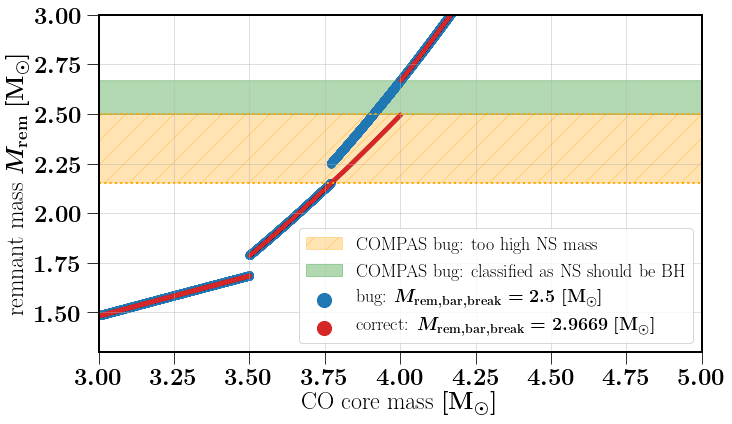

In [25]:


COCoreMassList = np.linspace(3, 8, 100000)
# StarMass = COCoreMass*4
mrem_baryList = []
remnantslist0_1, remnantslist0_5, remnantslist1_0 = [], [], []
for ind, COCoreMass in enumerate(COCoreMassList):
    Mass = COCoreMass*4


    Mproto = FryerCOCoreToProtoMassDelayed(COCoreMass)
    fb = FryerFallbackDelayed(Mass, Mproto, COCoreMass)
    Mfb = FryerMassFallbackGeneral(Mass, Mproto, fb);
    Mrem_bary = FryerBaryonicRemnantMassGeneral(Mproto, Mfb);
    mrem_baryList.append(Mrem_bary)
    
    Mrem_grav0_1 = FryerGravitationalRemnantMassGeneral(Mrem_bary, 0.1,2.5);
    Mrem_grav0_5 = FryerGravitationalRemnantMassGeneral(Mrem_bary, 0.1,2.9669);
    Mrem_grav1_0 = FryerGravitationalRemnantMassGeneral(Mrem_bary, 1,2.5);
    remnantslist0_1.append(Mrem_grav0_1)
    remnantslist0_5.append(Mrem_grav0_5)
    remnantslist1_0.append(Mrem_grav1_0)



f, axarr = plt.subplots(1, 1, figsize=(10, 6))

xx=np.linspace(3,5,1000)
axarr.plot(xx, len(xx)*[2.5], c='orange', lw=2, linestyle =':')
axarr.plot(xx, len(xx)*[FryerSolveQuadratic(0.075, 1.0, -2.5)], c='orange',lw=2, linestyle =':')
axarr.fill_between(x=xx,y1=np.ones_like(xx)*FryerSolveQuadratic(0.075, 1.0, -2.5),y2=np.ones_like(xx)*2.5,\
                   color='orange', alpha = 0.3, hatch='/' , label = 'COMPAS bug: too high NS mass')
axarr.fill_between(x=xx,y1=np.ones_like(xx)*2.5\
                   ,y2=np.ones_like(xx)*2.9669*0.9, color='green', alpha = 0.3, label = 'COMPAS bug: classified as NS should be BH')



# plot given parameters for star 1 and star 2
axarr.scatter(COCoreMassList, remnantslist0_1, s = 50, c=colorlist[0], label = r'bug: $M_{\rm{rem,bar,break}}=2.5 $ $[\rm{M}_{\odot}]$')
axarr.scatter(COCoreMassList, remnantslist0_5, s = 5, c=colorlist[3], label = r'correct: $ M_{\rm{rem,bar,break}}=2.9669$ $[\rm{M}_{\odot}]$')


lgnd = plt.legend(markerscale=4, scatterpoints=1,fontsize = 18 , loc = 'lower right')
# set legend scatter point sizes 
lgnd.legendHandles[2]._sizes = [200]
lgnd.legendHandles[3]._sizes = [200]


axarr.grid(which='both')
axarr.grid(which='minor', alpha=0.2)
axarr.grid(which='major', alpha=0.5) 

axarr.grid(True)
axarr.tick_params(labelsize=24,)
axarr.set_xlabel(r'CO core mass  $[\rm{M}_{\odot}]$', fontsize=24)
axarr.set_ylabel(r' remnant mass $M_{\rm{rem}} $ $[\rm{M}_{\odot}]$', fontsize=24)     

axarr.set_xlim(3,5)
axarr.set_ylim(1.3,3)
plt.tight_layout()
plt.savefig('./remnantMassMnsmaxVariatios.png', dpi = 300)

plt.show()

# RAPID

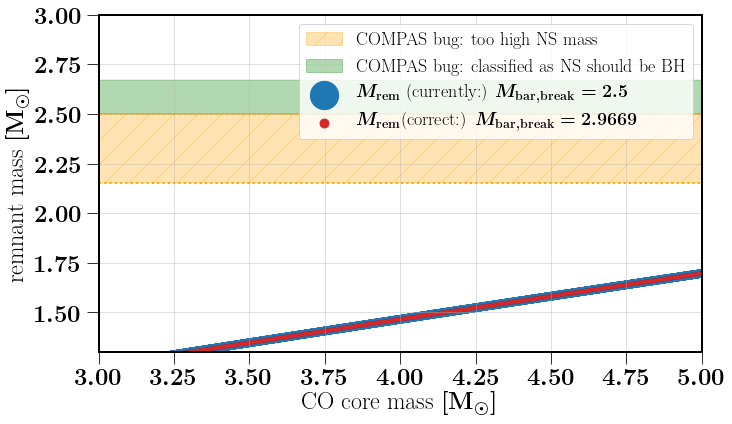

In [15]:

###### RAPID #######

COCoreMassList = np.linspace(3, 40, 100000)
# StarMass = COCoreMass*4
mrem_baryList = []
remnantslistRAPID0_1, remnantslistRAPID0_5, remnantslistRAPID1_0 = [], [], []
for ind, COCoreMass in enumerate(COCoreMassList):
    Mass = COCoreMass*4

    Mproto = FryerCOCoreToProtoMassRapid(COCoreMass); #// Calculate fb, Mfb
    fb = FryerFallbackRapid(Mass, Mproto, COCoreMass);
    Mfb = FryerMassFallbackGeneral(Mass, Mproto, fb);#// Calculate Mremnant, baryonic
    Mrem_bary = FryerBaryonicRemnantMassGeneral(Mproto, Mfb);
    
    
    Mrem_gravRAPID0_1 = FryerGravitationalRemnantMassGeneral(Mrem_bary, 0.1,2.5);
    Mrem_gravRAPID0_5 = FryerGravitationalRemnantMassGeneral(Mrem_bary, 0.1,2.9669);
    Mrem_gravRAPID1_0 = FryerGravitationalRemnantMassGeneral(Mrem_bary, 1,2.5);
    remnantslistRAPID0_1.append(Mrem_gravRAPID0_1)
    remnantslistRAPID0_5.append(Mrem_gravRAPID0_5)
    remnantslistRAPID1_0.append(Mrem_gravRAPID1_0)


f, axarr = plt.subplots(1, 1, figsize=(10, 6))

xx=np.linspace(3,20,1000)
axarr.plot(xx, len(xx)*[2.5], c='orange', lw=2, linestyle =':')
axarr.plot(xx, len(xx)*[FryerSolveQuadratic(0.075, 1.0, -2.5)], c='orange',lw=2, linestyle =':')
axarr.fill_between(x=xx,y1=np.ones_like(xx)*FryerSolveQuadratic(0.075, 1.0, -2.5),y2=np.ones_like(xx)*2.5,\
                   color='orange', alpha = 0.3, hatch='/' , label = 'COMPAS bug: too high NS mass')
axarr.fill_between(x=xx,y1=np.ones_like(xx)*2.5\
                   ,y2=np.ones_like(xx)*2.9669*0.9, color='green', alpha = 0.3, label = 'COMPAS bug: classified as NS should be BH')



# plot given parameters for star 1 and star 2
axarr.scatter(COCoreMassList, remnantslistRAPID0_1, s = 50, c=colorlist[0], label = r'$M_{\rm{rem}}$ (currently:) $M_{\rm{bar,break}}=2.5 $')
# axarr.scatter(COCoreMassList, mrem_baryList, s = 5, c=colorlist[1], label = r'$M_{\rm{rem,bary}}$  $M_{\rm{NS,max}}=2.5$')
axarr.scatter(COCoreMassList, remnantslistRAPID0_5, s = 5, c=colorlist[3], label = r'$M_{\rm{rem}}$(correct:) $ M_{\rm{bar,break}}=2.9669$')


axarr.legend(markerscale=4, scatterpoints=1,fontsize = 18 , loc = 'upper right')

axarr.grid(which='both')
axarr.grid(which='minor', alpha=0.2)
axarr.grid(which='major', alpha=0.5) 

axarr.grid(True)
axarr.tick_params(labelsize=24,)
axarr.set_xlabel(r'CO core mass  $[\rm{M}_{\odot}]$', fontsize=24)
axarr.set_ylabel(r'remnant mass $[\rm{M}_{\odot}]$', fontsize=24)     

axarr.set_xlim(3,5)
axarr.set_ylim(1.3,3)
plt.tight_layout()
plt.savefig('./remnantMassMnsmaxVariationsRAPID.png', dpi = 300)

plt.show()